In [14]:
#import pygmt
#import pyshtools as pysh
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import stripy
from gprm.utils.raster import write_xyz_file
import ptt.utils.call_system_command as call_system_command


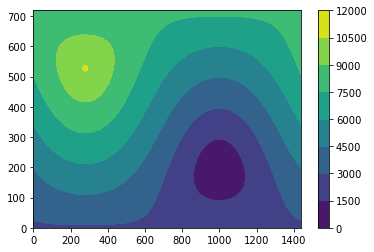

10669.445
10649.999095669398


In [15]:
CraterDistance = xr.open_dataarray('DistanceToHellasCentre.nc')

plt.contourf(CraterDistance.data)
plt.colorbar()
plt.show()

print(CraterDistance.data.max())
print(3390*np.pi)

inner_limit = 100.
outer_limit = 2000.

lons,lats = np.meshgrid(CraterDistance.lon.data, CraterDistance.lat.data)


In [25]:
# generic function to interpolate nans, based on a raster where the 
# there is a mixture of nans and real numbers
# values are only interpolated at the nodes specified
# by 'ind_hole', then mapped back into the raster
def interpolate_hole(lons, lats, ramping, ind_hole, method='stripy'):

    if method=='stripy':
        ind = np.isnan(ramping.flatten())
        basis_X = lons.flatten()[~ind]
        basis_Y = lats.flatten()[~ind]
        basis_Z = ramping.flatten()[~ind]   

        target_X = lons.flatten()[ind_hole]
        target_Y = lats.flatten()[ind_hole]

        tri = stripy.sTriangulation(lons=np.radians(basis_X.flatten()), lats=np.radians(basis_Y.flatten()))

        ramp_interp = tri.interpolate(np.radians(target_X), np.radians(target_Y),
                                              zdata=basis_Z,
                                              order=1)[0]

        ramping[np.unravel_index(ind_hole.nonzero(), ramping.shape)] = ramp_interp
        
    elif method=='greenspline':
        
        desamp = 2
        ind = np.isnan(ramping[::desamp,::desamp].flatten())
        basis_X = lons[::desamp,::desamp].flatten()[~ind]
        basis_Y = lats[::desamp,::desamp].flatten()[~ind]
        basis_Z = ramping[::desamp,::desamp].flatten()[~ind]   

        target_X = lons.flatten()[ind_hole]
        target_Y = lats.flatten()[ind_hole]
        
        # Save to an ascii file
        np.savetxt('tmp.xyz', np.vstack((basis_X, 
                                         basis_Y, 
                                         basis_Z)).T, fmt='%1.12f')
                                        
        call_system_command(['gmt', 'greenspline', 'tmp.xyz', '-V', '-RDistanceToHellasCentre.nc', 
                             '-Sp', '-Z3', '-Gtmp.nc', '-Ttmpmask.nc'])
                                        
        ramp_interp = xr.open_dataarray('tmp.nc')
        
        ramping[np.unravel_index(ind_hole.nonzero(), ramping.shape)] = ramp_interp.data.flatten()[ind_hole]
        
    
    return ramping





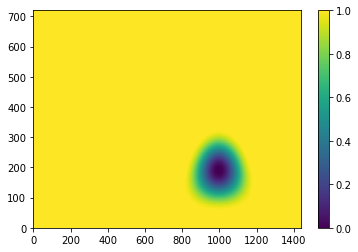

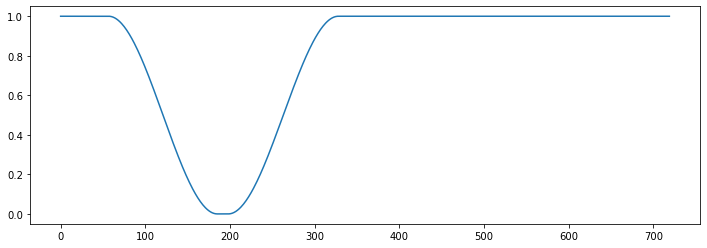

In [17]:
ramping = CraterDistance.data.copy()

# Set ramping to be zero outside big circle, and pi inside small circle
# set to nan in between, so that we can linearly interpolate
ramping[CraterDistance.data>outer_limit] = 0.
ramping[CraterDistance.data<outer_limit] = np.nan
ramping[CraterDistance.data<inner_limit] = np.pi

# keep an index of the nodes inside the hole
ind_hole = np.isnan(ramping.flatten())

# now, mask out the points far from either circle to speed up the spherical interpolation
ramping[CraterDistance.data>outer_limit*1.25] = np.nan

# call function to interpolate the ring of nans
ramping = interpolate_hole(lons, lats, ramping, ind_hole)

# Set the values far beyond the circle to 0
ramping[CraterDistance.data>outer_limit*1.25] = 0.

# Now we have a function that is linear from 0 to pi
# apply the cosine function, then scale to go from 0 in centre to one at edge
ramping = (np.cos(ramping)+1) / 2.

plt.pcolormesh(ramping)
plt.colorbar()
plt.show()

plt.figure(figsize=(12,4))
plt.plot(ramping[:,1000])
plt.show()


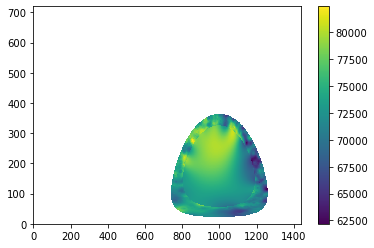

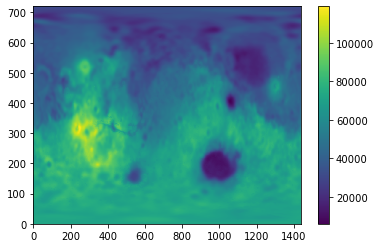

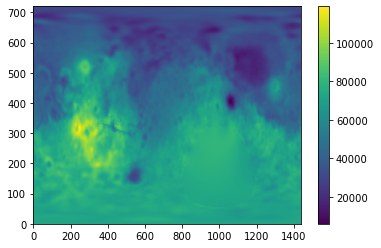

In [26]:
HM = np.loadtxt('grids/W19_l90.xyz')

sus = HM[:,2].reshape(720,1440)
sus = np.hstack((sus[:,720:],sus[:,:720]))

sus_in = sus.copy()
sus_orig = sus.copy()


sus[CraterDistance.data<outer_limit] = np.nan

ind_hole = np.isnan(sus.flatten())
mskgrd = CraterDistance.copy()
mskgrd.data = np.logical_not(np.isnan(sus))
mskgrd.to_netcdf('tmpmask.nc')


sus[CraterDistance.data>outer_limit*1.25] = np.nan

#plt.contourf(sus)
#plt.colorbar()
#plt.show()

sus = interpolate_hole(lons, lats, sus, ind_hole, method='greenspline')

sus_in[np.unravel_index(ind_hole.nonzero(), sus.shape)] = sus[np.unravel_index(ind_hole.nonzero(), sus.shape)]


plt.pcolormesh(sus)
plt.colorbar()
plt.show()

plt.pcolormesh(sus_orig)
plt.colorbar()
plt.show()

plt.pcolormesh(sus_in)
plt.colorbar()
plt.show()


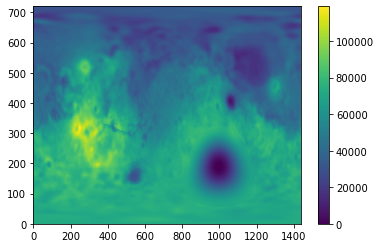

In [27]:
plt.pcolormesh(sus_in * ramping)
plt.colorbar()
plt.show()

In [28]:
cthick_modified = sus_in * ramping

fmt = '%1.3f', '%1.3f', '%1.12f'
# Save to an ascii file
np.savetxt('grids/W19_l90_hellas_cosine_ramp_function_mincurv.xyz', np.vstack((lons.flatten(), 
                                lats.flatten(), 
                                cthick_modified.flatten())).T, fmt=fmt)

# Save to an ascii file
np.savetxt('grids/W19_l90_hellas_removed_mincurv.xyz', np.vstack((lons.flatten(), 
                                lats.flatten(), 
                                sus_in.flatten())).T, fmt=fmt)

<ipython-input-21-cec3f56b3c4c>:45: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(lons,lats,sus)


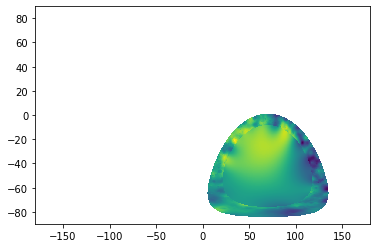

In [21]:
HM = np.loadtxt('grids/W19_l90.xyz')

sus = HM[:,2].reshape(720,1440)
sus = np.hstack((sus[:,720:],sus[:,:720]))

sus_in = sus.copy()
sus_orig = sus.copy()


sus[CraterDistance.data<outer_limit] = np.nan

ind_hole = np.isnan(sus.flatten())
mskgrd = CraterDistance.copy()
mskgrd.data = np.logical_not(np.isnan(sus))
mskgrd.to_netcdf('tmpmask.nc')


sus[CraterDistance.data>outer_limit*1.25] = np.nan


#sus = interpolate_hole(lons, lats, sus, ind_hole, method='greenspline')

desamp = 5
ind = np.isnan(sus[::desamp,::desamp].flatten())
basis_X = lons[::desamp,::desamp].flatten()[~ind]
basis_Y = lats[::desamp,::desamp].flatten()[~ind]
basis_Z = sus[::desamp,::desamp].flatten()[~ind]   

target_X = lons.flatten()[ind_hole]
target_Y = lats.flatten()[ind_hole]

# Save to an ascii file
np.savetxt('tmp.xyz', np.vstack((basis_X, 
                                 basis_Y, 
                                 basis_Z)).T, fmt='%1.12f')

call_system_command(['gmt', 'greenspline', 'tmp.xyz', '-V', '-RDistanceToHellasCentre.nc', 
                     '-Sp', '-Z3', '-Gtmp.nc', '-Ttmpmask.nc'])

sus_interp = xr.open_dataarray('tmp.nc')

sus[np.unravel_index(ind_hole.nonzero(), sus.shape)] = sus_interp.data.flatten()[ind_hole]


plt.pcolormesh(lons,lats,sus)